In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

#Dataset:
Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes

Dataset Characteristics :
Multivariate

Subject Area :
Business

Associated Tasks:
Regression

Feature Type :
Integer, Real

Instances :
8760

Features:
13

In [2]:
dataset_cols=["bike_count","hour","temp","humidity","windspeed","visibility","dew_point","solar_rad","rainfall","snowfall","functional"]
df=pd.read_csv("SeoulBikeData.csv").drop(['Date','Holiday','Seasons'],axis=1)
df.head(20)

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,0.0,Yes
5,100,5,-6.4,37,1.5,2000,-18.7,0.00,0.0,0.0,Yes
6,181,6,-6.6,35,1.3,2000,-19.5,0.00,0.0,0.0,Yes
7,460,7,-7.4,38,0.9,2000,-19.3,0.00,0.0,0.0,Yes
8,930,8,-7.6,37,1.1,2000,-19.8,0.01,0.0,0.0,Yes
9,490,9,-6.5,27,0.5,1928,-22.4,0.23,0.0,0.0,Yes


In [3]:
df.columns=dataset_cols
df["functional"]=(df["functional"]=='Yes').astype(int)
df=df[df['hour']==12]
df=df.drop(['hour'],axis=1)
df.head()

,bike_count,temp,humidity,windspeed,visibility,dew_point,solar_rad,rainfall,snowfall,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


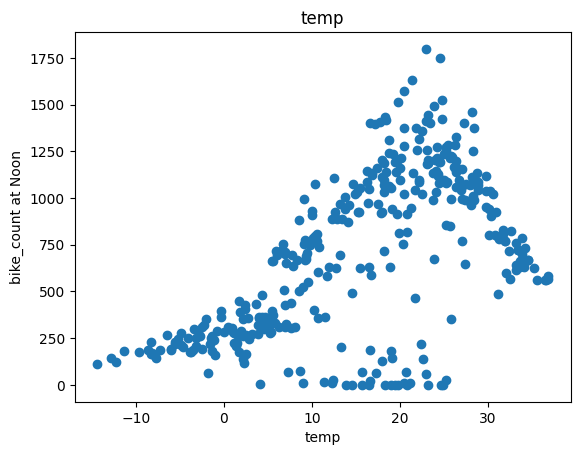

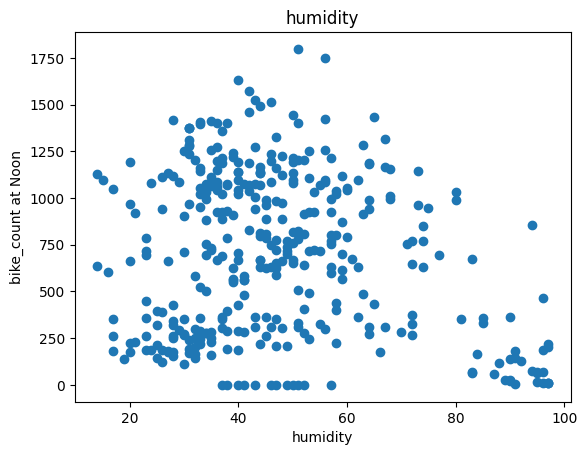

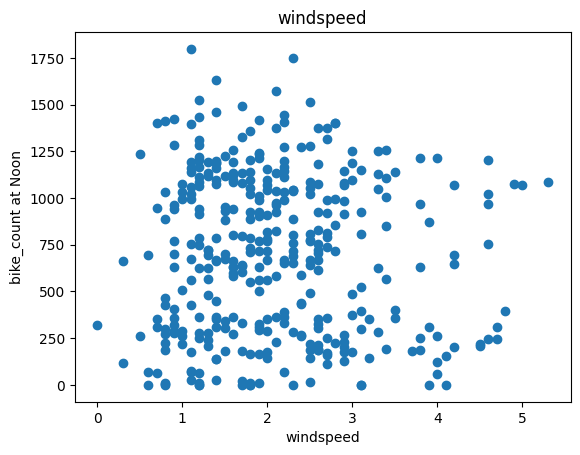

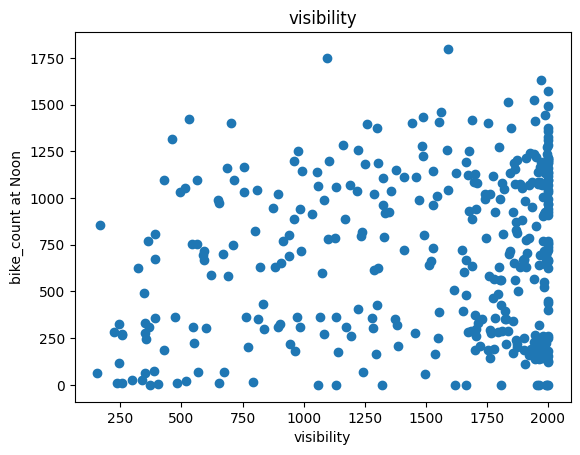

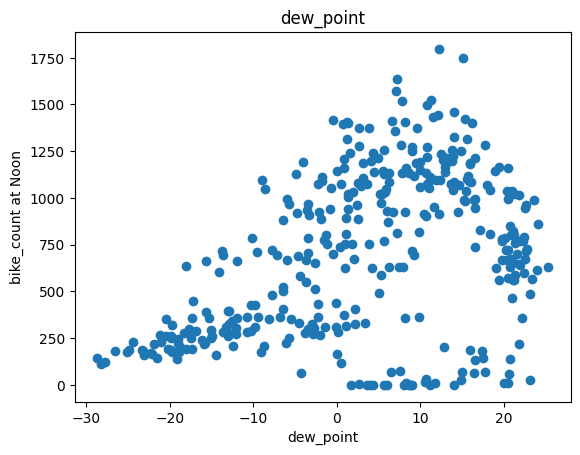

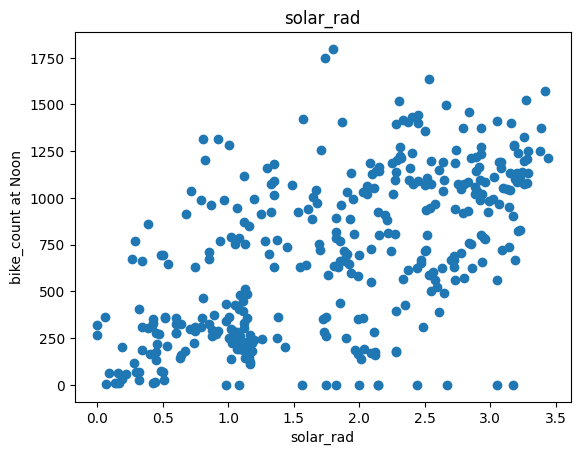

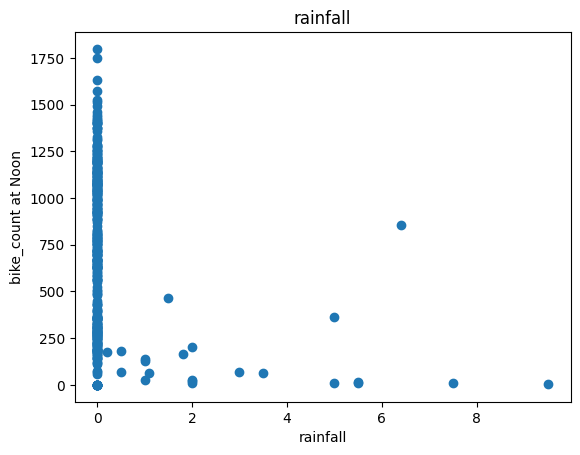

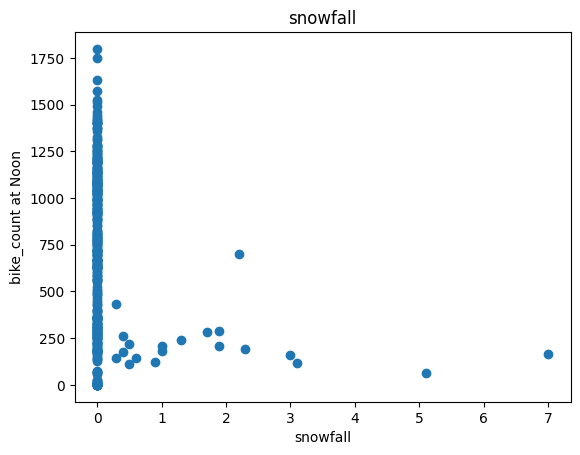

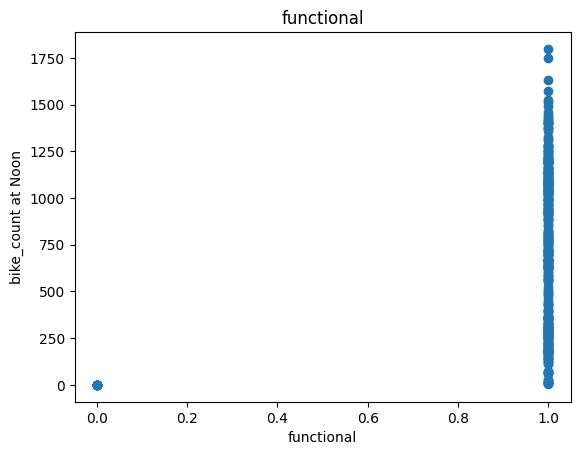

In [4]:
for label in df.columns[1:]:
  plt.scatter(df[label],df['bike_count'])
  plt.title(label)
  plt.xlabel(label)
  plt.ylabel('bike_count at Noon')
  plt.show()

In [5]:
# we can see that visibility wind and functional don't affect the number of bikes so we gonna drop them
df = df.drop(['visibility','windspeed','functional'],axis=1)

In [6]:
df.head()

,bike_count,temp,humidity,dew_point,solar_rad,rainfall,snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


#Train /valid/ Test datasets

In [7]:
train ,valid , test =np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
def get_xy(dataframe,y_label, x_labels=None):
  dataframe=copy.deepcopy(dataframe)
  if  x_labels is None:
    X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels)==1:
      X=dataframe[x_labels[0]].values.reshape(-1,1)
    else:
     X=dataframe[x_labels].values

  y=dataframe[y_label].values.reshape(-1,1)
  data =np.hstack((X,y))

  return data, X,y

#Simple linear regression

In [9]:
_,X_train_temp,y_train_temp=get_xy(train,'bike_count',x_labels=['temp'])
_,X_valid_temp,y_valid_temp=get_xy(valid,'bike_count',x_labels=['temp'])
_,X_test_temp,y_test_temp=get_xy(test,'bike_count',x_labels=['temp'])

In [10]:
X_train_temp

array([[ 26.3],
       [  9.3],
       [ 35.2],
       [ 33.8],
       [ 30.2],
       [ 14.2],
       [ -6.5],
       [ 30.9],
       [ -3.4],
       [ 25.2],
       [ 15.2],
       [  9.1],
       [ 22.6],
       [ 25.7],
       [  0.9],
       [ 33.6],
       [ 33.4],
       [ 16.8],
       [ 25.2],
       [ 33.9],
       [  4. ],
       [ 18.2],
       [-12.8],
       [  2.5],
       [ 13.2],
       [ 30.1],
       [ 28.7],
       [ 20. ],
       [ 27.4],
       [ 23.1],
       [ 19.4],
       [ 15.3],
       [ 10.7],
       [ 17.3],
       [ 33.2],
       [  3.2],
       [  4.3],
       [ -3.2],
       [ 24.7],
       [ 14.9],
       [  5.4],
       [ 15.5],
       [ 21.2],
       [ -8.3],
       [ 12.3],
       [ 22.5],
       [ 22.9],
       [  4.3],
       [ 30.3],
       [ -1.6],
       [ 21.5],
       [ 24.5],
       [ 20. ],
       [ 16.5],
       [ 30.1],
       [ 13.7],
       [ -2.5],
       [ 33.6],
       [ 18.2],
       [ 13.3],
       [ 24.5],
       [  8.1],
       [

In [11]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp,y_train_temp)

LinearRegression()

In [12]:
print(temp_reg.coef_,temp_reg.intercept_)
#coef_ w1 :coeff of the feature temp
#intercept_ :w0 or bias (the value of the prediction when all input features are 0)

[[19.73426757]] [390.73180966]


In [13]:
temp_reg.score(X_test_temp,y_test_temp)#𝑅2 score (coeff de correlation)


0.27151351513118116

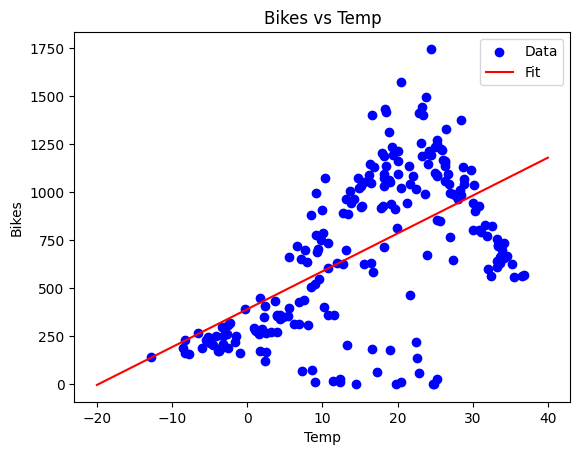

In [14]:
plt.scatter(X_train_temp,y_train_temp,label="Data",color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(tf.reshape(x,(-1,1))),label="Fit",color="red")
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bikes")
plt.xlabel("Temp")
plt.show()

#Multiple linear regression

In [15]:
_,X_train_all,y_train_all=get_xy(train,'bike_count',x_labels=df.columns[1:])
_,X_valid_all,y_valid_all=get_xy(valid,'bike_count',x_labels=df.columns[1:])
_,X_test_all,y_test_all=get_xy(test,'bike_count',x_labels=df.columns[1:])

In [16]:
all_reg=LinearRegression()
all_reg.fit(X_train_all,y_train_all)

LinearRegression()

In [17]:
all_reg.score(X_test_all,y_test_all)

0.39252501774736737

#Regression with Neural net

Simple lin.Reg

In [18]:
#1) for temp only(one feature) :
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
#axis=None means normalization is done globally — across all values, not per feature.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [20]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError())

In [21]:
def plot_history(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [22]:
history=temp_nn_model.fit(X_train_temp.reshape(-1),y_train_temp,verbose=1,epochs=1000,validation_data=(X_valid_temp,y_valid_temp))

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 658332.5625 - val_loss: 558015.7500
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 632674.5000 - val_loss: 556935.2500
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 646588.6875 - val_loss: 555861.1250
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 634287.6250 - val_loss: 554790.2500
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 696177.6250 - val_loss: 553717.0625
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 730724.6250 - val_loss: 552648.1250
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 625903.2500 - val_loss: 551607.0000
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 681079.6250 - val_loss: 550551.1875
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 697562.8125 - val_loss: 549495.5625
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 678424.0000 - val_loss: 548435.2500
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

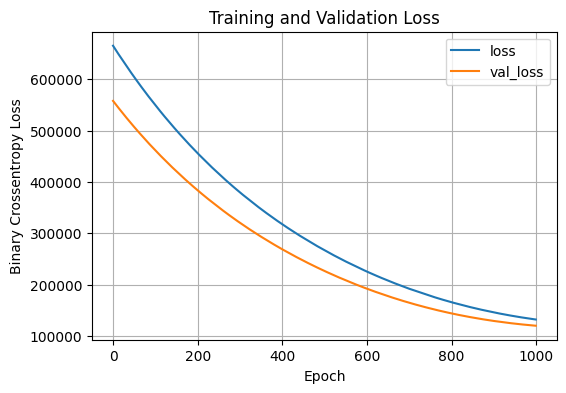

In [23]:
plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


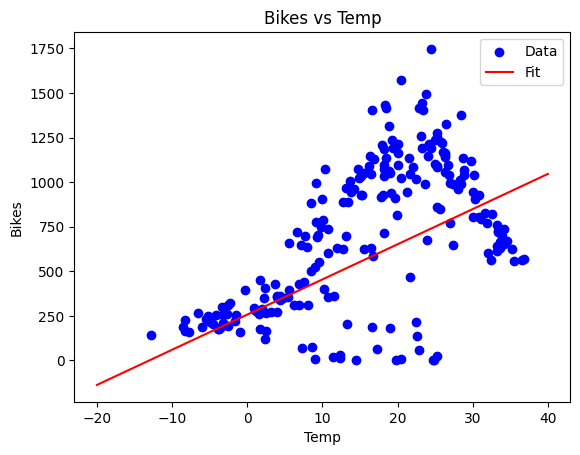

In [24]:
plt.scatter(X_train_temp,y_train_temp,label="Data",color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(tf.reshape(x,(-1,1))),label="Fit",color="red")
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bikes")
plt.xlabel("Temp")
plt.show()

Multiple lin.Reg

In [25]:
#1) for temp only(one feature) :
all_normalizer=tf.keras.layers.Normalization(input_shape=(X_train_all.shape[1],),axis=-1)
all_normalizer.adapt(X_train_all)
#axis=None means normalization is done globally — across all values, not per feature.

In [26]:
all_nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1)
])

In [27]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError())

In [28]:
history=all_nn_model.fit(X_train_all,y_train_all,verbose=0,epochs=1000,validation_data=(X_valid_all,y_valid_all))

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 638777.7500 - val_loss: 556909.6250
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 702628.5000 - val_loss: 555159.6875
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 663073.5000 - val_loss: 553415.4375
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 648680.3750 - val_loss: 551721.3750
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 639708.3750 - val_loss: 550044.1250
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 647531.8125 - val_loss: 548354.3125
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 636608.8750 - val_loss: 546699.1875
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 660289.9375 - val_loss: 545024.2500
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 682804.4375 - val_loss: 543368.7500
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 628440.3125 - val_loss: 541776.6875
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/st

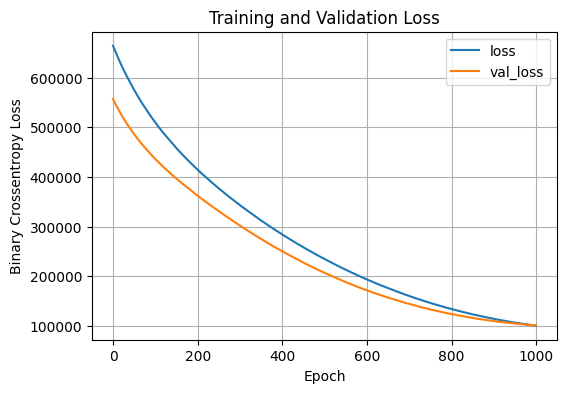

In [29]:
plot_history(history)

#Neural net (real one)






Temp feature

In [42]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))
nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError())

In [43]:
history=nn_model.fit(X_train_temp,y_train_temp,verbose=0,epochs=100,validation_data=(X_valid_temp,y_valid_temp))

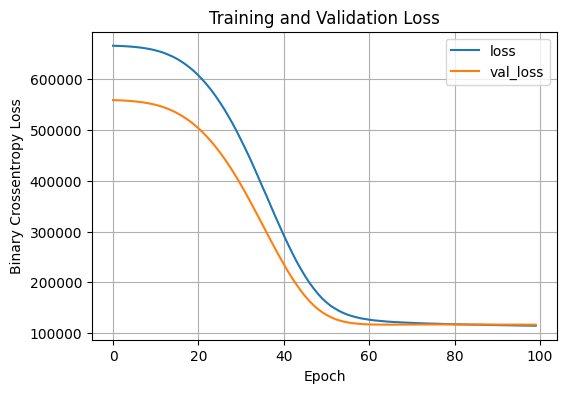

In [44]:
plot_history(history)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


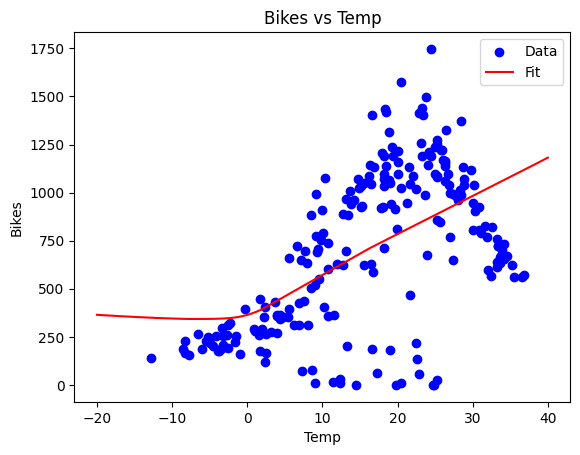

In [45]:
plt.scatter(X_train_temp,y_train_temp,label="Data",color="blue")
x=tf.linspace(-20,40,100)
plt.plot(x,nn_model.predict(tf.reshape(x,(-1,1))),label="Fit",color="red")
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Bikes")
plt.xlabel("Temp")
plt.show()

All features

In [72]:
nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='relu')
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.MeanSquaredError())

In [73]:
history=nn_model.fit(X_train_all,y_train_all,verbose=0,epochs=100,validation_data=(X_valid_all,y_valid_all))

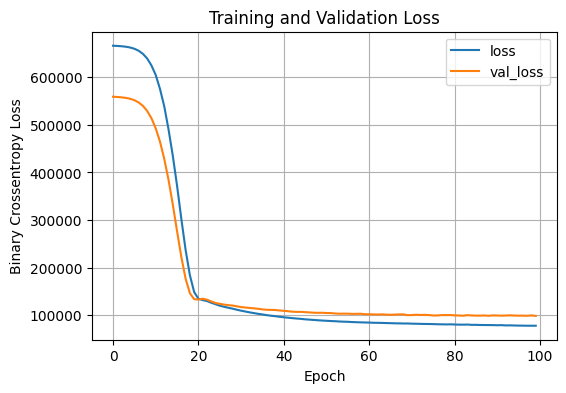

In [68]:
plot_history(history)

In [74]:
#calculate the MSE for both lin_reg  and nn
y_pred_lr=all_reg.predict(X_test_all)
y_pred_nn=nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [60]:
def MSE(y_pred,y_real):
  return (np.square(y_pred-y_real)).mean()

In [63]:
MSE(y_pred_lr,y_test_all)

np.float64(134576.2899900682)

In [75]:
MSE(y_pred_nn,y_test_all)

np.float64(124760.54428239915)

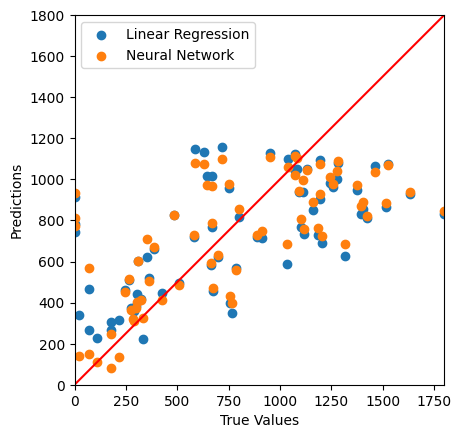

In [76]:
ax=plt.axes(aspect='equal')
plt.scatter(y_test_all, y_pred_lr,label='Linear Regression')
plt.scatter(y_test_all, y_pred_nn,label='Neural Network')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims,c='red')